## Setup

In [19]:
from importlib import reload

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas


from hot_dust import preprocess, model

In [20]:
# "reload" to get changes in preprocess.py without restarting the kernel
reload(preprocess)
reload(model)
from hot_dust.preprocess import prepare_training_data, split_training_data
from hot_dust.model import to_tensorflow

In [21]:
ds = prepare_training_data()
train, validate, test = to_tensorflow(split_training_data(ds))
batch_size = test.cardinality()
test = test.batch(batch_size)

## Model Summary

In [22]:
network = tf.keras.models.load_model("data/network")
network.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 11)]              0         
                                                                 
 normalization_4 (Normaliza  (None, 11)                23        
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 32)                384       
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 440 (1.72 KB)
Trainable params: 417 (1.63 KB)
Non-trainable params: 23 (96.00 Byte)
_________________________________________________________________


## Metrics

In [23]:
# Calculate metrics (.eg MSE, R2) on test data and tabulate

y = np.concatenate(list(i[1] for i in test.as_numpy_iterator()))  # true values
y_hat = network.predict(test, verbose=0).reshape((-1,))  # predicted values

# Calculate the MSE
MSE = np.square(np.subtract(y, y_hat)).mean()

# Calculate R2
mean_y = np.mean(y)  # mean of the true values
SS_total = np.sum((y - mean_y) ** 2)  # total sum of squares
SS_reg = np.sum((y - y_hat) ** 2)  #  sum of squares due to regression

R2 = 1 - (SS_reg / SS_total)

# Calculate Variance
variance = np.var(y_hat)

# Return the metrics
print("Metrics: ")
print("Mean Squared Error: " + str(MSE))
print("R2: " + str(R2))
print("Variance of the Predictions: " + str(variance))

Metrics: 
Mean Squared Error: 0.11468275
R2: 0.8754401430487633
Variance of the Predictions: 0.8092615


## Plots

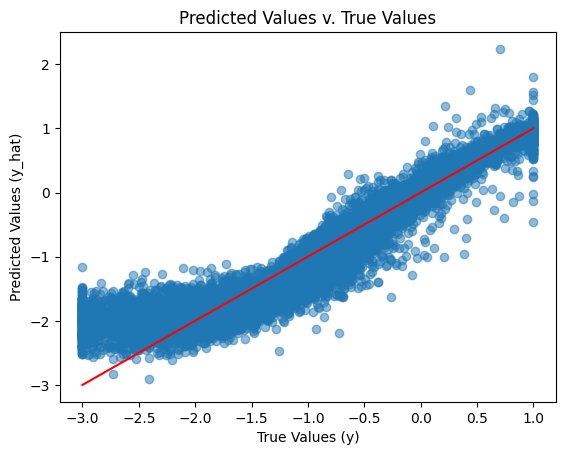

In [24]:
# Plot of y_hat against y, with a one-to-one line overlayed
# plot y_hat against y
plt.scatter(y, y_hat, alpha=0.5)

# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Values")

# one-to-one line overlay
plt.plot([min(y), max(y)], [min(y), max(y)], color="red")

Text(0.5, 1.0, 'Histogram of the Residuals')

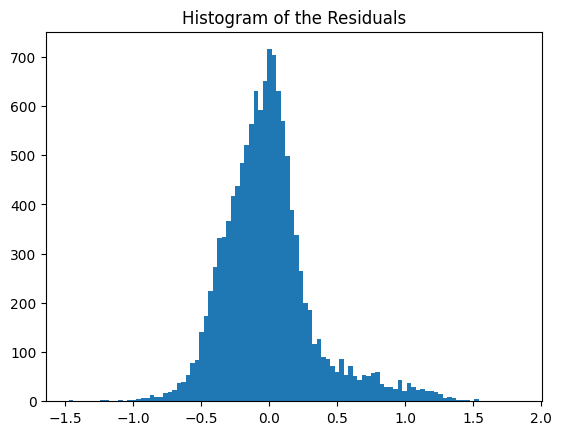

In [25]:
# Plot a histogram of the residuals
residual = y_hat - y
num_bins = 100
plt.hist(residual, num_bins)
plt.title("Histogram of the Residuals")

Text(0.5, 1.0, 'Residuals v. True Values')

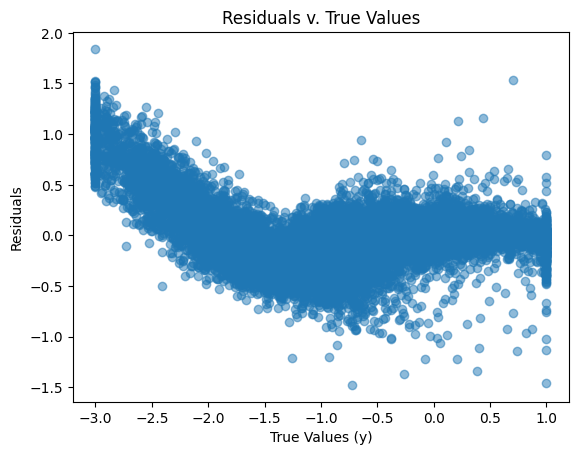

In [26]:
# Plot of the residuals against y
plt.scatter(y, residual, alpha=0.5)
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Values")

## Heat Maps 

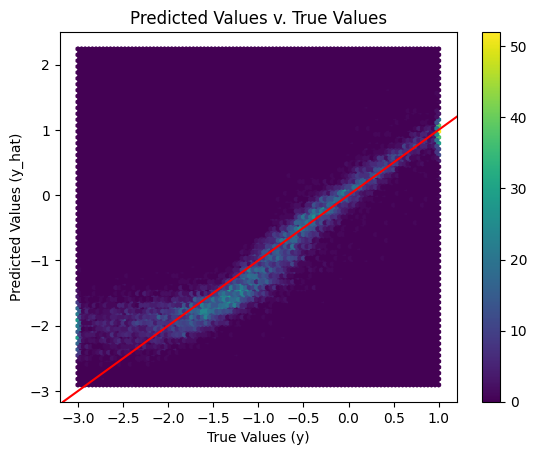

In [27]:
# Heat map of y_hat against y

# create the heatmap of y_hat against y
plt.hexbin(y, y_hat, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Predicted Values (y_hat)")
plt.title("Predicted Values v. True Values")
# one-to-one line overlay
plt.axline([0, 0], slope=1, color="red")
plt.colorbar()

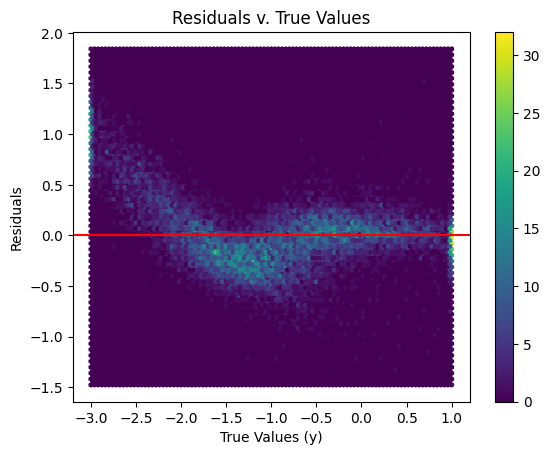

In [28]:
# Heat map of the residuals against y

# create the heatmap of residuals against y
plt.hexbin(y, residual, cmap="viridis")
# set the size of the graph
plt.axis("auto")
# lables
plt.xlabel("True Values (y)")
plt.ylabel("Residuals")
plt.title("Residuals v. True Values")
# zero horizontal line overlay
plt.axline([0, 0], slope=0, color="red")
plt.colorbar()